In [1]:
import numpy as np
import pandas as pd

np.random.seed(42)

n_samples = 1000

data = {
    "Orbital_Radius": np.random.uniform(0.3, 50, n_samples),
    "Orbital_Velocity": np.random.uniform(1, 70, n_samples),
    "Mass": np.random.uniform(0.01, 200, n_samples),
    "Time_Step": np.random.uniform(0.1, 365, n_samples),
    "Inclination": np.random.uniform(0, 180, n_samples)
}

df = pd.DataFrame(data)

# Simulated output (proxy for Celestia observation)
df["Stability_Score"] = (
    1 / (1 + np.exp(
        0.02*df["Orbital_Velocity"]
        - 0.03*df["Mass"]
        + 0.01*df["Inclination"]
    ))
)

df.head()


,Orbital_Radius,Orbital_Velocity,Mass,Time_Step,Inclination,Stability_Score
0,18.914644,13.774172,52.348520,245.569323,102.959258,0.565958
1,47.550501,38.391165,49.403290,290.809042,144.977819,0.323988
2,36.680099,61.233263,181.251854,91.495736,136.828967,0.945039
3,30.053327,51.523517,49.916745,228.116559,27.701983,0.547361
4,8.054126,56.652719,54.397226,208.730109,26.864905,0.557300


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import time
import numpy as np
import pandas as pd

X = df.drop("Stability_Score", axis=1)
y = df["Stability_Score"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor(),
    "Gradient Boosting": GradientBoostingRegressor()
}

results = []

for name, model in models.items():
    start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start

    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append([name, mae, rmse, r2, train_time])

results_df = pd.DataFrame(
    results,
    columns=["Model", "MAE", "RMSE", "R2 Score", "Training Time (s)"]
)

results_df


,Model,MAE,RMSE,R2 Score,Training Time (s)
0,Linear Regression,0.069924,0.080099,0.923871,0.020627
1,Random Forest,0.019881,0.029714,0.989523,1.603600
2,SVR,0.053588,0.059888,0.957444,0.006980
3,KNN,0.037102,0.053613,0.965894,0.004272
4,Gradient Boosting,0.016860,0.024852,0.992671,0.569754


In [4]:
results_df


,Model,MAE,RMSE,R2 Score,Training Time (s)
0,Linear Regression,0.069924,0.080099,0.923871,0.020627
1,Random Forest,0.019881,0.029714,0.989523,1.603600
2,SVR,0.053588,0.059888,0.957444,0.006980
3,KNN,0.037102,0.053613,0.965894,0.004272
4,Gradient Boosting,0.016860,0.024852,0.992671,0.569754


In [5]:
import pandas as pd

rank_df = results_df.copy()

# Create individual ranks
rank_df["MAE_rank"] = rank_df["MAE"].rank(ascending=True)
rank_df["RMSE_rank"] = rank_df["RMSE"].rank(ascending=True)
rank_df["R2_rank"] = rank_df["R2 Score"].rank(ascending=False)
rank_df["Time_rank"] = rank_df["Training Time (s)"].rank(ascending=True)

# Final average rank
rank_df["Final_Rank_Score"] = (
    rank_df["MAE_rank"] +
    rank_df["RMSE_rank"] +
    rank_df["R2_rank"] +
    rank_df["Time_rank"]
)

# Final ranking
rank_df["Rank"] = rank_df["Final_Rank_Score"].rank(ascending=True).astype(int)

# Sort by rank
rank_df = rank_df.sort_values("Rank")

rank_df[["Model", "Final_Rank_Score", "Rank"]]


,Model,Final_Rank_Score,Rank
4,Gradient Boosting,7.0,1
3,KNN,10.0,2
1,Random Forest,11.0,3
2,SVR,14.0,4
0,Linear Regression,18.0,5


In [6]:
best_model = rank_df.iloc[0]["Model"]
best_model


'Gradient Boosting'

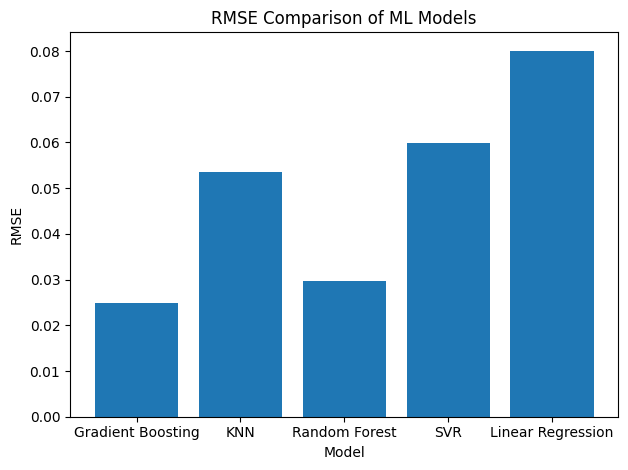

In [7]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(rank_df["Model"], rank_df["RMSE"])
plt.title("RMSE Comparison of ML Models")
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.tight_layout()
plt.savefig("rmse_comparison.png")
plt.show()


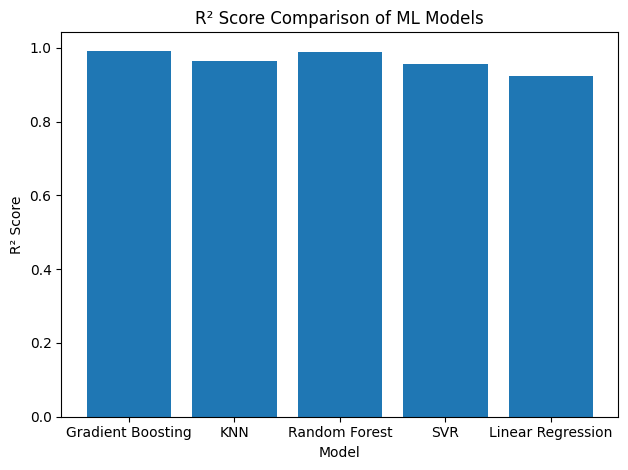

In [8]:
plt.figure()
plt.bar(rank_df["Model"], rank_df["R2 Score"])
plt.title("R² Score Comparison of ML Models")
plt.ylabel("R² Score")
plt.xlabel("Model")
plt.tight_layout()
plt.savefig("r2_comparison.png")
plt.show()


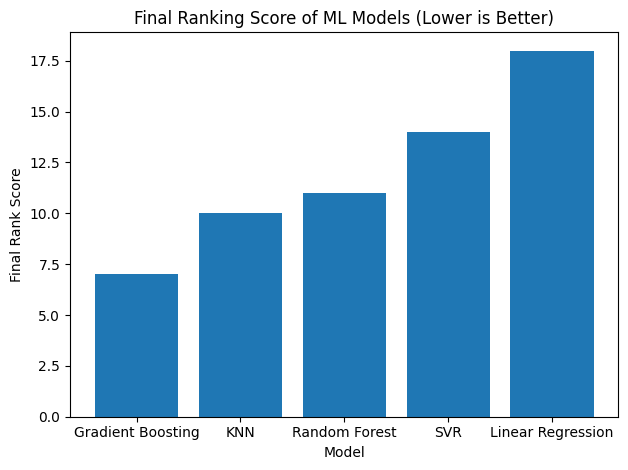

In [9]:
plt.figure()
plt.bar(rank_df["Model"], rank_df["Final_Rank_Score"])
plt.title("Final Ranking Score of ML Models (Lower is Better)")
plt.ylabel("Final Rank Score")
plt.xlabel("Model")
plt.tight_layout()
plt.savefig("final_rank_scores.png")
plt.show()


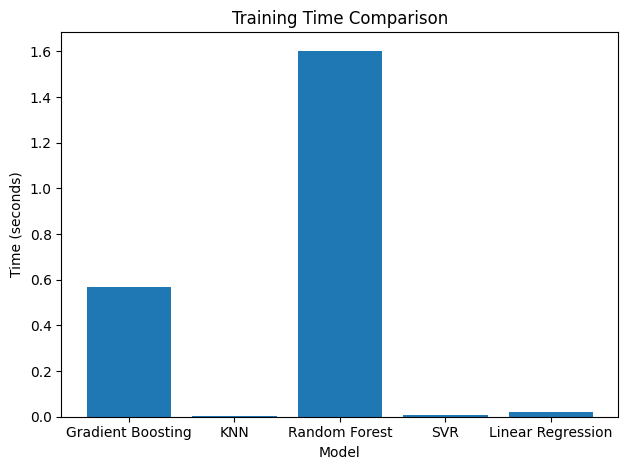

In [10]:
plt.figure()
plt.bar(rank_df["Model"], rank_df["Training Time (s)"])
plt.title("Training Time Comparison")
plt.ylabel("Time (seconds)")
plt.xlabel("Model")
plt.tight_layout()
plt.savefig("training_time.png")
plt.show()


In [11]:
# Exclude output column
parameter_bounds = df.drop(columns=["Stability_Score"]).agg(['min', 'max']).T

parameter_bounds.columns = ["Lower Bound", "Upper Bound"]
parameter_bounds


,Lower Bound,Upper Bound
Orbital_Radius,0.530212,49.985968
Orbital_Velocity,1.222060,69.959547
Mass,0.012327,199.564193
Time_Step,0.338422,364.838606
Inclination,0.005529,179.594890
